In [ ]:
!pip install cvxpy

In [ ]:
# Only run once!!
import os

os.chdir("../src/")

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names
from samplers import get_data_sampler
from tasks import get_task_sampler, SparseLinearRegression
from tasks import LinearRegression as LinearRegressionTask


import matplotlib as mpl
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, SGDRegressor, Ridge
import numpy as np
import cvxpy
from cvxpy import Variable, Minimize, Problem
from cvxpy import norm as cvxnorm

# from cvxpy import mul_elemwise, SCS
from cvxpy import vec as cvxvec

%matplotlib inline

sns.set_theme("notebook", "darkgrid")
palette = sns.color_palette("colorblind")
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["text.usetex"] = True

matplotlib.rcParams.update(
    {
        "axes.titlesize": 8,
        "figure.titlesize": 10,  # was 10
        "legend.fontsize": 12,  # was 10
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
    }
)
run_dir = " ../models/"

In [3]:
SPINE_COLOR = "gray"
# def latexify(fig_width=1.25, fig_height=1.25, columns=1):
#     """Set up matplotlib's RC params for LaTeX plotting.
#     Call this before plotting a figure.

#     Parameters
#     ----------
#     fig_width : float, optional, inches
#     fig_height : float,  optional, inches
#     columns : {1, 2}
#     """

#     # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

#     # Width and max height in inches for IEEE journals taken from
#     # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

#     assert(columns in [1,2])

#     if fig_width is None:
#         fig_width = 3.39 if columns==1 else 6.9 # width in inches

#     if fig_height is None:
#         golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
#         fig_height = fig_width*golden_mean # height in inches

#     MAX_HEIGHT_INCHES = 8.0
#     if fig_height > MAX_HEIGHT_INCHES:
#         print("WARNING: fig_height too large:" + fig_height +
#               "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
#         fig_height = MAX_HEIGHT_INCHES

#     params = {'backend': 'ps',
#            'axes.labelsize': 4, # fontsize for x and y labels (was 10)
#               'axes.titlesize': 8,
#               'figure.titlesize': 8, # was 10
#               'legend.fontsize': 4, # was 10
#               'xtick.labelsize': 6,
#               'ytick.labelsize': 6,
#               'axes.labelpad': 1,
#               'text.usetex': True,
#               'figure.figsize': [fig_width,fig_height],
# #               'font.family': 'calibri',
#               'savefig.pad_inches':0,
# #               'figure.constrained_layout.h_pad':0,
# #               'figure.constrained_layout.w_pad':0,
# #               'axes.xmargin': 0,
# #               'axes.ymargin': 0,
#               'xtick.major.pad':0.2,
#               'ytick.major.pad':0.2,
#             #   'legend.fontsize': 4,
#             #   'legend.borderaxespad': 2
#             #   'legend.labelspacing':
#             #   'legend.loc':
#     }

#     matplotlib.rcParams.update(params)


def format_axes(ax):
    for spine in ["top", "right"]:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    for spine in ["left", "bottom"]:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position("bottom")
    ax.yaxis.set_ticks_position("left")

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction="out", color=SPINE_COLOR)
    return ax

In [11]:
cuda_device = "cuda:1"

lr_sr_svr_mixture_path = "../models/three_task_mixer/final_model_dr_sr_svr/"  # Change according to the id of the model you train
lr_single_path = "../models/linear_regression/final_model_w_posenc"  # Change according to the id of the model you train
sr_single_path = "../models/sparse_linear_regression/final_model_w_posenc"  # Change according to the id of the model you train
svr_single_path = "../models/sign_vec_cs/final_model_w_posenc"  # Change according to the id of the model you train


lr_sr_svr_model, lr_sr_svr_conf = get_model_from_run(lr_sr_svr_mixture_path)
lr_model, lr_conf = get_model_from_run(lr_single_path)
sr_model, sr_conf = get_model_from_run(sr_single_path)
svr_model, svr_conf = get_model_from_run(svr_single_path)


lr_sr_svr_model.to(cuda_device)
lr_model.to(cuda_device)
sr_model.to(cuda_device)
svr_model.to(cuda_device)

TransformerModel(
  (_read_in): Linear(in_features=20, out_features=256, bias=True)
  (_backbone): GPT2Model(
    (wte): Embedding(50257, 256)
    (wpe): Embedding(202, 256)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropou

In [13]:
batch_size = 1280  # 1280 #conf.training.batch_size
n_dims = 20
n_points = lr_sr_svr_conf.training.curriculum.points.end
data_sampler = get_data_sampler(lr_sr_svr_conf.training.data, n_dims)
task_sampler = get_task_sampler(
    lr_sr_svr_conf.training.task,
    n_dims,
    batch_size,
    **lr_sr_svr_conf.training.task_kwargs
)

In [14]:
sr_conf.training.task_kwargs["sparsity"]

3

In [17]:
seed = 42
torch.manual_seed(seed)
# lr_sr_conf.training.task_kwargs.update({"normalize_outputs": True})
lr_conf.training.task_kwargs.update({"normalize_outputs": True})
sr_conf.training.task_kwargs.update({"normalize_outputs": True})
svr_conf.training.task_kwargs.update({"normalize_outputs": True})

mix_task = get_task_sampler(
    lr_sr_svr_conf.training.task,
    n_dims,
    batch_size,
    **lr_sr_svr_conf.training.task_kwargs
)()

lr_task = get_task_sampler(
    lr_conf.training.task, n_dims, batch_size, **lr_conf.training.task_kwargs
)()

sr_task = get_task_sampler(
    sr_conf.training.task, n_dims, batch_size, **sr_conf.training.task_kwargs
)()

svr_task = get_task_sampler(
    svr_conf.training.task, n_dims, batch_size, **svr_conf.training.task_kwargs
)()

xs = data_sampler.sample_xs(b_size=batch_size, n_points=n_points)

lr_ys = lr_task.evaluate(xs)
sr_ys = sr_task.evaluate(xs)
svr_ys = svr_task.evaluate(xs)

In [18]:
sr_task.normalize_outputs

True

In [19]:
sr_ys.max()

tensor(7.1756)

In [11]:
# lr_task = LinearRegressionTask(n_dims, batch_size, normalize_outputs = True)

# sr_task = SparseLinearRegression(n_dims, batch_size,
#                                  sparsity = sr_conf.training.task_kwargs["sparsity"],
#                                  normalize_outputs = True)

In [21]:
with torch.no_grad():
    print("Getting LR Preds for Mixture Model")
    mix_transformer_lr_preds = lr_sr_svr_model(
        xs.to(cuda_device), lr_ys.to(cuda_device)
    ).cpu()
    print("Getting SR Preds for Mixture Model")
    mix_transformer_sr_preds = lr_sr_svr_model(
        xs.to(cuda_device), sr_ys.to(cuda_device)
    ).cpu()
    print("Getting SVR Preds for Mixture Model")
    mix_transformer_svr_preds = lr_sr_svr_model(
        xs.to(cuda_device), svr_ys.to(cuda_device)
    ).cpu()
    print("Getting LR Preds for LR Model")
    lr_transformer_lr_preds = lr_model(xs.to(cuda_device), lr_ys.to(cuda_device)).cpu()
    print("Getting LR Preds for SR Model")
    sr_transformer_lr_preds = sr_model(xs.to(cuda_device), lr_ys.to(cuda_device)).cpu()
    print("Getting LR Preds for SVR Model")
    svr_transformer_lr_preds = svr_model(
        xs.to(cuda_device), lr_ys.to(cuda_device)
    ).cpu()

    print("Getting SR Preds for SR Model")
    sr_transformer_sr_preds = sr_model(xs.to(cuda_device), sr_ys.to(cuda_device)).cpu()
    print("Getting SR Preds for LR Model")
    lr_transformer_sr_preds = lr_model(xs.to(cuda_device), sr_ys.to(cuda_device)).cpu()
    print("Getting SR Preds for SVR Model")
    svr_transformer_sr_preds = svr_model(
        xs.to(cuda_device), sr_ys.to(cuda_device)
    ).cpu()

    print("Getting SVR Preds for SVR Model")
    svr_transformer_svr_preds = svr_model(
        xs.to(cuda_device), svr_ys.to(cuda_device)
    ).cpu()
    print("Getting SVR Preds for LR Model")
    lr_transformer_svr_preds = lr_model(
        xs.to(cuda_device), svr_ys.to(cuda_device)
    ).cpu()
    print("Getting SVR Preds for SR Model")
    sr_transformer_svr_preds = sr_model(
        xs.to(cuda_device), svr_ys.to(cuda_device)
    ).cpu()

Getting LR Preds for Mixture Model
Getting SR Preds for Mixture Model
Getting SVR Preds for Mixture Model
Getting LR Preds for LR Model
Getting LR Preds for SR Model
Getting LR Preds for SVR Model
Getting SR Preds for SR Model
Getting SR Preds for LR Model
Getting SR Preds for SVR Model
Getting SVR Preds for SVR Model
Getting SVR Preds for LR Model
Getting SVR Preds for SR Model


In [27]:
metric = lr_task.get_metric()
mix_transformer_lr_errors = metric(mix_transformer_lr_preds, lr_ys).numpy().squeeze()
mix_transformer_sr_errors = metric(mix_transformer_sr_preds, sr_ys).numpy().squeeze()
mix_transformer_svr_errors = metric(mix_transformer_svr_preds, svr_ys).numpy().squeeze()

lr_transformer_lr_errors = metric(lr_transformer_lr_preds, lr_ys).numpy().squeeze()
lr_transformer_sr_errors = metric(lr_transformer_sr_preds, sr_ys).numpy().squeeze()
lr_transformer_svr_errors = metric(lr_transformer_svr_preds, svr_ys).numpy().squeeze()

sr_transformer_lr_errors = metric(sr_transformer_lr_preds, lr_ys).numpy().squeeze()
sr_transformer_sr_errors = metric(sr_transformer_sr_preds, sr_ys).numpy().squeeze()
sr_transformer_svr_errors = metric(sr_transformer_svr_preds, svr_ys).numpy().squeeze()


svr_transformer_lr_errors = metric(svr_transformer_lr_preds, lr_ys).numpy().squeeze()
svr_transformer_sr_errors = metric(svr_transformer_sr_preds, sr_ys).numpy().squeeze()
svr_transformer_svr_errors = metric(svr_transformer_svr_preds, svr_ys).numpy().squeeze()

In [23]:
def get_lsq_pred_nd_errors(xs, ys):
    lsq_preds = [np.zeros(xs.shape[0])]
    lsq_weights = []
    for i in tqdm(range(1, xs.shape[1])):
        preds = []
        weights = []
        for batch_id in range(xs.shape[0]):
            lsq_model = LinearRegression(fit_intercept=False)
            preds.append(
                lsq_model.fit(xs[batch_id, :i], ys[batch_id, :i]).predict(
                    xs[batch_id, i : i + 1]
                )[0]
            )
            weights.append(lsq_model.coef_)
        preds = np.array(preds).squeeze()
        lsq_preds.append(preds)
        lsq_weights.append(weights)
    lsq_preds = np.array(lsq_preds)
    lsq_preds = torch.tensor(lsq_preds.T).float()
    lsq_errors = metric(lsq_preds, ys).numpy().squeeze()
    lsq_weights = np.array(lsq_weights)

    return lsq_preds, lsq_errors, torch.tensor(lsq_weights).float()

In [15]:
print("Getting Errors for LR Prompts")
_, ols_lr_errors, ols_lr_weights = get_lsq_pred_nd_errors(xs, lr_ys)
print("Getting Errors for SR Prompts")
_, ols_sr_errors, ols_sr_weights = get_lsq_pred_nd_errors(xs, sr_ys)

Getting Errors for LR Prompts


  0%|          | 0/40 [00:00<?, ?it/s]

Getting Errors for SR Prompts


  0%|          | 0/40 [00:00<?, ?it/s]

In [16]:
ols_lr_weights.shape

torch.Size([40, 1280, 20])

In [16]:
def get_ridge_pred_nd_errors(xs, ys):
    ridge_preds = [np.zeros(xs.shape[0])]
    for i in tqdm(range(1, xs.shape[1])):
        preds = []
        for batch_id in range(xs.shape[0]):
            preds.append(
                Ridge(fit_intercept=False, alpha=1e-2)
                .fit(xs[batch_id, :i], ys[batch_id, :i])
                .predict(xs[batch_id, i : i + 1])[0]
            )
        preds = np.array(preds).squeeze()
        ridge_preds.append(preds)
    ridge_preds = np.array(ridge_preds)
    ridge_preds = torch.tensor(ridge_preds.T).float()

    ridge_errors = metric(ridge_preds, ys).numpy().squeeze()

    return ridge_preds, ridge_errors

In [17]:
print("Getting Errors for LR Prompts")
_, ridge_lr_errors = get_ridge_pred_nd_errors(xs, lr_ys)

Getting Errors for LR Prompts


  0%|          | 0/40 [00:00<?, ?it/s]

In [17]:
def get_lasso_pred_nd_errors(xs, ys):
    lasso_preds = [np.zeros(xs.shape[0])]
    lasso_weights = []
    for i in tqdm(range(1, xs.shape[1])):
        preds = []
        weights = []
        for batch_id in range(xs.shape[0]):
            lasso_model = Lasso(fit_intercept=False, alpha=1e-2)
            preds.append(
                lasso_model.fit(xs[batch_id, :i], ys[batch_id, :i]).predict(
                    xs[batch_id, i : i + 1]
                )[0]
            )
            weights.append(lasso_model.coef_)
        preds = np.array(preds).squeeze()
        lasso_preds.append(preds)
        lasso_weights.append(weights)

    lasso_preds = np.array(lasso_preds)
    lasso_preds = torch.tensor(lasso_preds.T).float()

    lasso_errors = metric(lasso_preds, ys).numpy().squeeze()

    return lasso_preds, lasso_errors, torch.tensor(lasso_weights).float()

In [ ]:
print("Getting Errors for SR Prompts")
_, lasso_sr_errors, lasso_sr_weights = get_lasso_pred_nd_errors(xs, sr_ys)
print("Getting Errors for LR Prompts")
_, lasso_lr_errors, lasso_lr_weights = get_lasso_pred_nd_errors(xs, lr_ys)

In [24]:
def get_df_from_pred_array(pred_arr, n_points, offset=0):
    # pred_arr --> b x pts-1
    batch_size = pred_arr.shape[0]
    flattened_arr = pred_arr.ravel()
    points = np.array(list(range(offset, n_points)) * batch_size)
    df = pd.DataFrame({"y": flattened_arr, "x": points})
    return df


def lineplot_with_ci(pred_or_err_arr, n_points, offset, label, ax, seed):
    sns.lineplot(
        data=get_df_from_pred_array(pred_or_err_arr, n_points=n_points, offset=offset),
        y="y",
        x="x",
        label=label,
        ax=ax,
        n_boot=1000,
        seed=seed,
        ci=90,
    )

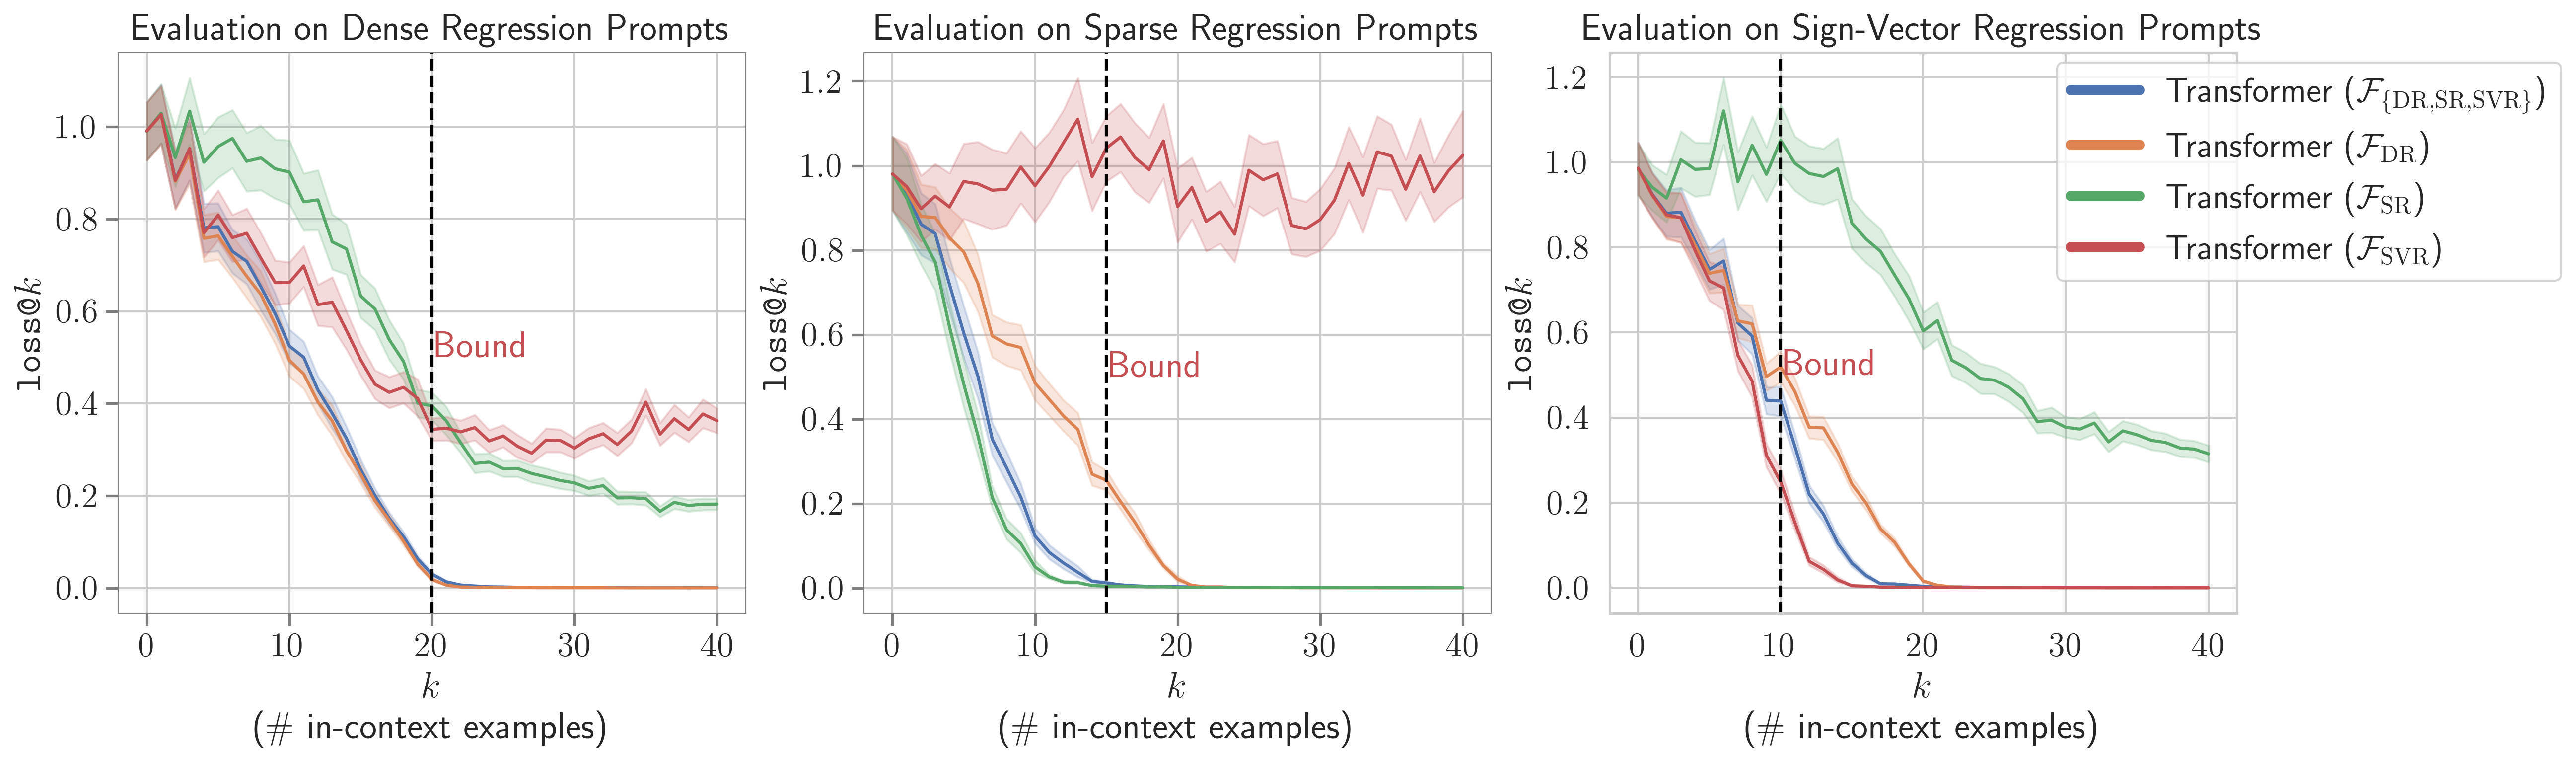

In [29]:
import math

sns.set(style="whitegrid", font_scale=1.5)
# latexify(4, 3)

lr_bound = n_dims
s = sr_conf.training.task_kwargs["sparsity"]
sr_bound = int(2 * s * math.log(n_dims / s) + 5 * s / 4)
svr_bound = n_dims // 2

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
# ax.plot(list(range(n_points)), transformer_pe_errors.mean(axis=0), label = "With Position Encodings")
# ax.plot(list(range(n_points)), transformer_no_pe_errors.mean(axis=0), label = "Without Position Encodings")
lineplot_with_ci(
    mix_transformer_lr_errors,
    n_points,
    offset=0,
    label="Transformer ($\mathcal{F}_{\{\mathrm{DR},\mathrm{SR}, \mathrm{SVR}\}}$)",
    ax=ax1,
    seed=seed,
)
lineplot_with_ci(
    lr_transformer_lr_errors,
    n_points,
    offset=0,
    label="Transformer ($\mathcal{F}_{\mathrm{DR}}$)",
    ax=ax1,
    seed=seed,
)
lineplot_with_ci(
    sr_transformer_lr_errors,
    n_points,
    offset=0,
    label="Transformer ($\mathcal{F}_{\mathrm{SR}}$)",
    ax=ax1,
    seed=seed,
)
lineplot_with_ci(
    svr_transformer_lr_errors,
    n_points,
    offset=0,
    label="Transformer ($\mathcal{F}_{\mathrm{SVR}}$)",
    ax=ax1,
    seed=seed,
)

# lineplot_with_ci(ols_lr_errors, n_points,offset = 0, label="OLS", ax=ax1, seed=seed)
# lineplot_with_ci(lasso_lr_errors, n_points,offset = 0, label="Lasso", ax=ax1, seed=seed)
# lineplot_with_ci(l2_norm_errors, n_points, label="L-2 Norm Min", ax=ax, seed=seed)
ax1.set_xlabel("$k$\n(\# in-context examples)")
ax1.set_ylabel("$\\texttt{loss@}k$")
ax1.set_title("Evaluation on Dense Regression Prompts")
ax1.axvline(lr_bound, ls="--", color="black")
ax1.annotate("Bound", xy=(lr_bound + 0.25, 0.5), color="r", rotation=0)
format_axes(ax1)

lineplot_with_ci(
    mix_transformer_sr_errors,
    n_points,
    offset=0,
    label="Transformer ($\mathcal{F}_{\{\mathrm{DR},\mathrm{SR},  \mathrm{SVR}\}}$)",
    ax=ax2,
    seed=seed,
)
lineplot_with_ci(
    lr_transformer_sr_errors,
    n_points,
    offset=0,
    label="Transformer ($\mathcal{F}_{\mathrm{DR}}$)",
    ax=ax2,
    seed=seed,
)
lineplot_with_ci(
    sr_transformer_sr_errors,
    n_points,
    offset=0,
    label="Transformer ($\mathcal{F}_{\mathrm{SR}}$)",
    ax=ax2,
    seed=seed,
)
lineplot_with_ci(
    svr_transformer_sr_errors,
    n_points,
    offset=0,
    label="Transformer ($\mathcal{F}_{\mathrm{SVR}}$)",
    ax=ax2,
    seed=seed,
)


# lineplot_with_ci(ols_sr_errors, n_points,offset = 0, label="OLS", ax=ax2, seed=seed)
# lineplot_with_ci(lasso_sr_errors, n_points,offset = 0, label="Lasso", ax=ax2, seed=seed)
# lineplot_with_ci(l2_norm_errors, n_points, label="L-2 Norm Min", ax=ax, seed=seed)
ax2.set_xlabel("$k$\n(\# in-context examples)")
ax2.set_ylabel("$\\texttt{loss@}k$")
ax2.set_title("Evaluation on Sparse Regression Prompts")
ax2.axvline(sr_bound, ls="--", color="black")
ax2.annotate("Bound", xy=(sr_bound + 0.25, 0.5), color="r", rotation=0)
format_axes(ax2)


lineplot_with_ci(
    mix_transformer_svr_errors,
    n_points,
    offset=0,
    label="Transformer ($\mathcal{F}_{\{\mathrm{DR},\mathrm{SR},  \mathrm{SVR}\}}$)",
    ax=ax3,
    seed=seed,
)
lineplot_with_ci(
    lr_transformer_svr_errors,
    n_points,
    offset=0,
    label="Transformer ($\mathcal{F}_{\mathrm{DR}}$)",
    ax=ax3,
    seed=seed,
)
lineplot_with_ci(
    sr_transformer_svr_errors,
    n_points,
    offset=0,
    label="Transformer ($\mathcal{F}_{\mathrm{SR}}$)",
    ax=ax3,
    seed=seed,
)
lineplot_with_ci(
    svr_transformer_svr_errors,
    n_points,
    offset=0,
    label="Transformer ($\mathcal{F}_{\mathrm{SVR}}$)",
    ax=ax3,
    seed=seed,
)
# lineplot_with_ci(ols_svr_errors, n_points,offset = 0, label="OLS", ax=ax3 seed=seed)
# lineplot_with_ci(linf_svr_errors[:, :n_dims + 1], n_dims + 1, offset = 0, label="Minimize $\ell_{\infty}$", ax=ax3, seed=seed)
# lineplot_with_ci(l2_norm_errors, n_points, label="L-2 Norm Min", ax=ax, seed=seed)
ax3.set_xlabel("$k$\n(\# in-context examples)")
ax3.set_ylabel("$\\texttt{loss@}k$")
ax3.set_title("Evaluation on Sign-Vector Regression Prompts")
ax3.axvline(svr_bound, ls="--", color="black")
ax3.annotate("Bound", xy=(svr_bound + 0.25, 0.5), color="r", rotation=0)
format_axes(ax2)


ax1.legend().set_visible(False)
ax2.legend().set_visible(False)
ax3.legend().set_visible(False)
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
handles, labels = ax1.get_legend_handles_labels()
leg = fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.15, 0.95))
# leg = plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1))
for line in leg.get_lines():
    line.set_linewidth(5)
plt.savefig("final_plots/lr_sr_svr_mix_errors.pdf", dpi=300, bbox_inches="tight")
plt.show()

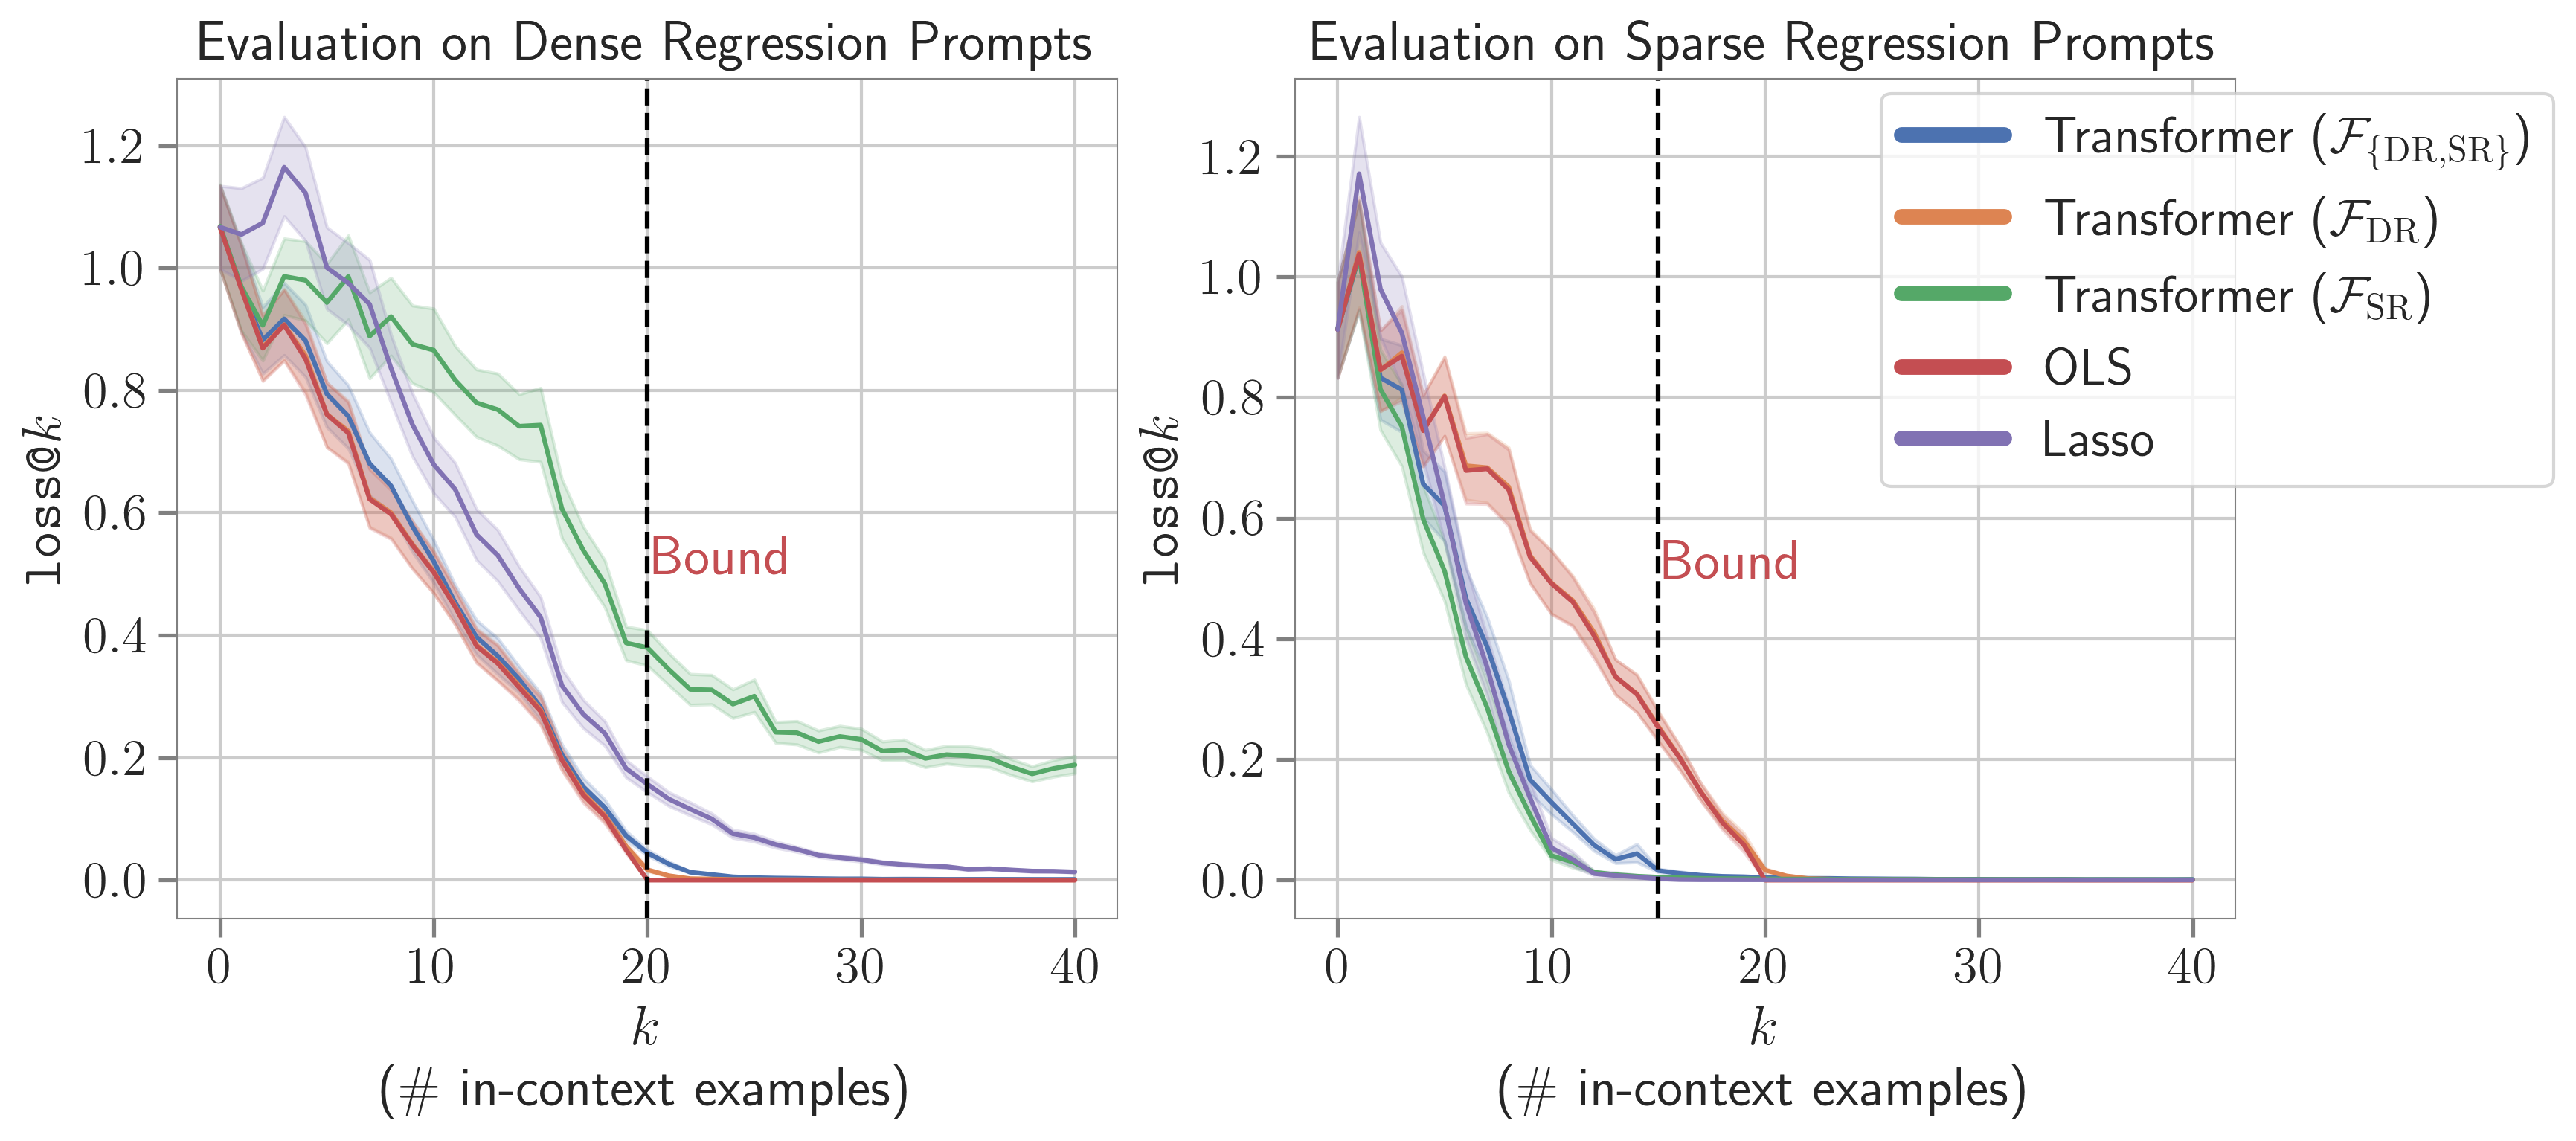

In [101]:
sns.set(style="whitegrid", font_scale=1.5)
# latexify(4, 3)

lr_bound = n_dims
s = sr_conf.training.task_kwargs["sparsity"]
sr_bound = int(2 * s * math.log(n_dims / s) + 5 * s / 4)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
# ax.plot(list(range(n_points)), transformer_pe_errors.mean(axis=0), label = "With Position Encodings")
# ax.plot(list(range(n_points)), transformer_no_pe_errors.mean(axis=0), label = "Without Position Encodings")
lineplot_with_ci(
    mix_transformer_lr_errors,
    n_points,
    offset=0,
    label="Transformer ($\mathcal{F}_{\{\mathrm{DR},\mathrm{SR}\}}$)",
    ax=ax1,
    seed=seed,
)
lineplot_with_ci(
    lr_transformer_lr_errors,
    n_points,
    offset=0,
    label="Transformer ($\mathcal{F}_{\mathrm{DR}}$)",
    ax=ax1,
    seed=seed,
)
lineplot_with_ci(
    sr_transformer_lr_errors,
    n_points,
    offset=0,
    label="Transformer ($\mathcal{F}_{\mathrm{SR}}$)",
    ax=ax1,
    seed=seed,
)
lineplot_with_ci(ols_lr_errors, n_points, offset=0, label="OLS", ax=ax1, seed=seed)
lineplot_with_ci(lasso_lr_errors, n_points, offset=0, label="Lasso", ax=ax1, seed=seed)
# lineplot_with_ci(l2_norm_errors, n_points, label="L-2 Norm Min", ax=ax, seed=seed)
ax1.set_xlabel("$k$\n(\# in-context examples)")
ax1.set_ylabel("$\\texttt{loss@}k$")
ax1.set_title("Evaluation on Dense Regression Prompts")
ax1.axvline(lr_bound, ls="--", color="black")
ax1.annotate("Bound", xy=(lr_bound + 0.25, 0.5), color="r", rotation=0)
format_axes(ax1)

lineplot_with_ci(
    mix_transformer_sr_errors,
    n_points,
    offset=0,
    label="Transformer ($\mathcal{F}_{\{\mathrm{DR},\mathrm{SR}\}}$)",
    ax=ax2,
    seed=seed,
)
lineplot_with_ci(
    lr_transformer_sr_errors,
    n_points,
    offset=0,
    label="Transformer ($\mathcal{F}_{\mathrm{DR}}$)",
    ax=ax2,
    seed=seed,
)
lineplot_with_ci(
    sr_transformer_sr_errors,
    n_points,
    offset=0,
    label="Transformer ($\mathcal{F}_{\mathrm{SR}}$)",
    ax=ax2,
    seed=seed,
)
lineplot_with_ci(ols_sr_errors, n_points, offset=0, label="OLS", ax=ax2, seed=seed)
lineplot_with_ci(lasso_sr_errors, n_points, offset=0, label="Lasso", ax=ax2, seed=seed)
# lineplot_with_ci(l2_norm_errors, n_points, label="L-2 Norm Min", ax=ax, seed=seed)
ax2.set_xlabel("$k$\n(\# in-context examples)")
ax2.set_ylabel("$\\texttt{loss@}k$")
ax2.set_title("Evaluation on Sparse Regression Prompts")
ax2.axvline(sr_bound, ls="--", color="black")
ax2.annotate("Bound", xy=(sr_bound + 0.25, 0.5), color="r", rotation=0)
format_axes(ax2)

ax1.legend().set_visible(False)
ax2.legend().set_visible(False)

# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
handles, labels = ax1.get_legend_handles_labels()
leg = fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.15, 0.95))
# leg = plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1))
for line in leg.get_lines():
    line.set_linewidth(5)
plt.savefig("final_plots/lr_sr_mix_errors.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [20]:
def recover_weights_pv2(model, xs, ys, w_b, data_sampler):
    model.to(cuda_device)
    batch_size = xs.size(0)
    n_dims = w_b.size(1)

    x_probes = data_sampler.sample_xs(b_size=xs.shape[0], n_points=2 * xs.shape[-1] + 1)
    y_probes = []
    for i in range(2 * xs.shape[-1] + 1):
        x_prompt = torch.concat([xs, x_probes[:, i : i + 1, :]], axis=1)
        y_prompt = torch.concat([ys, torch.zeros(xs.shape[0], 1)], axis=1)
        with torch.no_grad():
            pred = model(x_prompt.to(cuda_device), y_prompt.to(cuda_device)).cpu()
        y_probes.append(pred[:, -1:])

    y_probes = torch.cat(y_probes, axis=1)
    w_probed = []

    for batch in range(len(x_probes)):
        x, y = x_probes[batch], y_probes[batch]
        probe_model = LinearRegression(fit_intercept=False)
        probe_model.fit(x, y)
        w_probed.append(torch.tensor(probe_model.coef_[np.newaxis]).float())

    w_probed = torch.cat(w_probed, axis=0)
    error = ((w_probed - w_b[:, :, 0]) ** 2).mean(axis=1).mean()
    cos_sim = torch.nn.CosineSimilarity(dim=1, eps=1e-6)(w_probed, w_b[:, :, 0]).mean()

    return w_b, w_probed, error, cos_sim

In [36]:
w_b, mix_w_lr_probed, error, cos_sim = recover_weights_pv2(
    lr_sr_model, xs[:, :-1], lr_ys[:, :-1], lr_task.w_b, data_sampler
)

In [21]:
mix_w_lr_probed_vecs = []
for n_points_i in tqdm(range(1, n_points)):
    _, w_probed, _, cos_sim = recover_weights_pv2(
        lr_sr_model,
        xs[:, :n_points_i],
        lr_ys[:, :n_points_i],
        lr_task.w_b,
        data_sampler,
    )
    mix_w_lr_probed_vecs.append(w_probed)

  0%|          | 0/40 [00:00<?, ?it/s]

In [22]:
mix_w_sr_probed_vecs = []
for n_points_i in tqdm(range(1, n_points)):
    _, w_probed, _, cos_sim = recover_weights_pv2(
        lr_sr_model,
        xs[:, :n_points_i],
        sr_ys[:, :n_points_i],
        sr_task.w_b,
        data_sampler,
    )
    mix_w_sr_probed_vecs.append(w_probed)

  0%|          | 0/40 [00:00<?, ?it/s]

In [23]:
lr_w_lr_probed_vecs = []
for n_points_i in tqdm(range(1, n_points)):
    _, w_probed, _, cos_sim = recover_weights_pv2(
        lr_model, xs[:, :n_points_i], lr_ys[:, :n_points_i], lr_task.w_b, data_sampler
    )
    lr_w_lr_probed_vecs.append(w_probed)

  0%|          | 0/40 [00:00<?, ?it/s]

In [24]:
sr_w_sr_probed_vecs = []
for n_points_i in tqdm(range(1, n_points)):
    _, w_probed, _, cos_sim = recover_weights_pv2(
        sr_model, xs[:, :n_points_i], sr_ys[:, :n_points_i], sr_task.w_b, data_sampler
    )
    sr_w_sr_probed_vecs.append(w_probed)

  0%|          | 0/40 [00:00<?, ?it/s]

In [31]:
import math

s = 3
mse_mix_trans_lr_lsq = []
mse_mix_trans_lr_lasso = []
mse_mix_trans_sr_lsq = []
mse_mix_trans_sr_lasso = []

mse_mix_trans_lr_lr_trans = []
mse_mix_trans_sr_sr_trans = []

mse_mix_trans_lr_gold = []
mse_mix_trans_sr_gold = []

lr_gold_weights = lr_task.w_b.squeeze() / math.sqrt(n_dims)
sr_gold_weights = sr_task.w_b.squeeze() / math.sqrt(s)
for n_points_i in tqdm(range(1, n_points)):
    mix_trans_lr_weight_vect = mix_w_lr_probed_vecs[n_points_i - 1].squeeze()
    mix_trans_sr_weight_vect = mix_w_sr_probed_vecs[n_points_i - 1].squeeze()
    lsq_lr_weight_vect = ols_lr_weights[n_points_i - 1].squeeze()
    lsq_sr_weight_vect = ols_sr_weights[n_points_i - 1].squeeze()
    lr_trans_lr_weight_vect = lr_w_lr_probed_vecs[n_points_i - 1].squeeze()
    sr_trans_sr_weight_vect = sr_w_sr_probed_vecs[n_points_i - 1].squeeze()

    lasso_lr_weight_vect = torch.tensor(lasso_lr_weights)[n_points_i - 1].squeeze()
    lasso_sr_weight_vect = torch.tensor(lasso_sr_weights)[n_points_i - 1].squeeze()

    mse_mix_trans_lr_lsq.append(
        (n_dims * (mix_trans_lr_weight_vect - lsq_lr_weight_vect) ** 2).mean(axis=-1)
    )
    mse_mix_trans_lr_lasso.append(
        (n_dims * (mix_trans_lr_weight_vect - lasso_lr_weight_vect) ** 2).mean(axis=-1)
    )
    mse_mix_trans_sr_lsq.append(
        (s * (mix_trans_sr_weight_vect - lsq_sr_weight_vect) ** 2).mean(axis=-1)
    )
    mse_mix_trans_sr_lasso.append(
        (s * (mix_trans_sr_weight_vect - lasso_sr_weight_vect) ** 2).mean(axis=-1)
    )

    mse_mix_trans_lr_lr_trans.append(
        (n_dims * (mix_trans_lr_weight_vect - lr_trans_lr_weight_vect) ** 2).mean(
            axis=-1
        )
    )
    mse_mix_trans_sr_sr_trans.append(
        (n_dims * (mix_trans_sr_weight_vect - sr_trans_sr_weight_vect) ** 2).mean(
            axis=-1
        )
    )

    mse_mix_trans_lr_gold.append(
        (n_dims * (mix_trans_lr_weight_vect - lr_gold_weights) ** 2).mean(axis=-1)
    )
    mse_mix_trans_sr_gold.append(
        (s * (mix_trans_sr_weight_vect - sr_gold_weights) ** 2).mean(axis=-1)
    )


#     lsq_weight_vect = lsq_weights[:, n_points_i - 1].squeeze()
#     lasso_weight_vect = lasso_weights[:, n_points_i - 1].squeeze()
#     l1_min_weight_vect = l1_norm_weights[:, min(n_points_i - 1, l1_norm_weights.shape[1] - 1)].squeeze()

#     mse_trans_lsq.append(((trans_weight_vect - lsq_weight_vect)**2).mean(axis = -1))
#     mse_trans_lasso.append(((trans_weight_vect - lasso_weight_vect)**2).mean(axis = -1))
#     mse_trans_l1min.append(((trans_weight_vect - l1_min_weight_vect)**2).mean(axis = -1))
#     mse_trans_gold.append(((trans_weight_vect - gold_weights.squeeze())**2).mean(axis = -1))

  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipykernel_13748/1523201709.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lasso_lr_weight_vect = torch.tensor(lasso_lr_weights)[n_points_i - 1].squeeze()
/tmp/ipykernel_13748/1523201709.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lasso_sr_weight_vect = torch.tensor(lasso_sr_weights)[n_points_i - 1].squeeze()


In [32]:
mse_mix_trans_lr_lsq = torch.vstack(mse_mix_trans_lr_lsq).transpose(0, 1)
mse_mix_trans_lr_lasso = torch.vstack(mse_mix_trans_lr_lasso).transpose(0, 1)
mse_mix_trans_sr_lsq = torch.vstack(mse_mix_trans_sr_lsq).transpose(0, 1)
mse_mix_trans_sr_lasso = torch.vstack(mse_mix_trans_sr_lasso).transpose(0, 1)

mse_mix_trans_lr_lr_trans = torch.vstack(mse_mix_trans_lr_lr_trans).transpose(0, 1)
mse_mix_trans_sr_sr_trans = torch.vstack(mse_mix_trans_sr_sr_trans).transpose(0, 1)

mse_mix_trans_lr_gold = torch.vstack(mse_mix_trans_lr_gold).transpose(0, 1)
mse_mix_trans_sr_gold = torch.vstack(mse_mix_trans_sr_gold).transpose(0, 1)

In [33]:
mse_mix_trans_lr_lasso.mean(0)

tensor([0.1525, 0.2091, 0.2084, 0.2035, 0.1965, 0.1961, 0.1881, 0.1907, 0.1846,
        0.1782, 0.1713, 0.1630, 0.1508, 0.1387, 0.1307, 0.1230, 0.1220, 0.1210,
        0.1218, 0.1204, 0.1139, 0.1015, 0.0885, 0.0746, 0.0639, 0.0548, 0.0474,
        0.0414, 0.0365, 0.0325, 0.0288, 0.0257, 0.0236, 0.0216, 0.0199, 0.0185,
        0.0171, 0.0160, 0.0151, 0.0142])

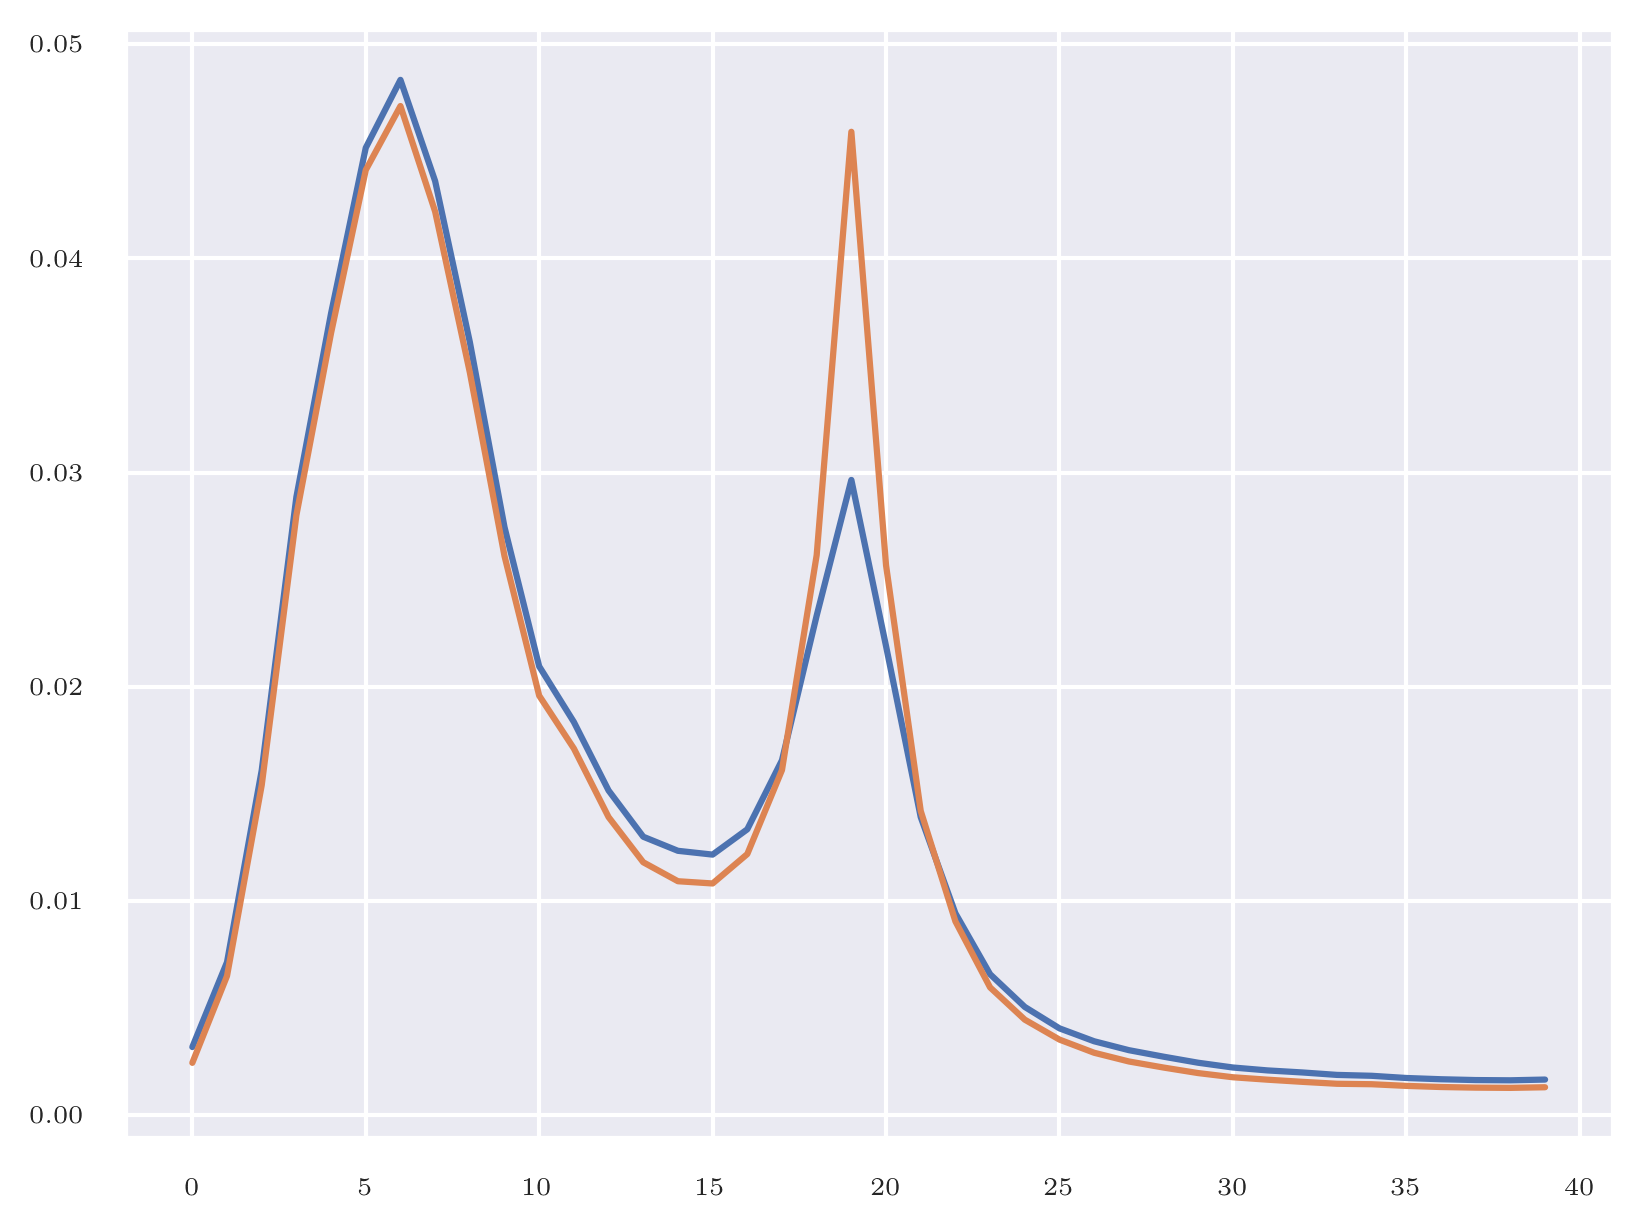

In [39]:
plt.plot(mse_mix_trans_lr_lr_trans.mean(0))
plt.plot(
    mse_mix_trans_lr_lsq.mean(0),
)

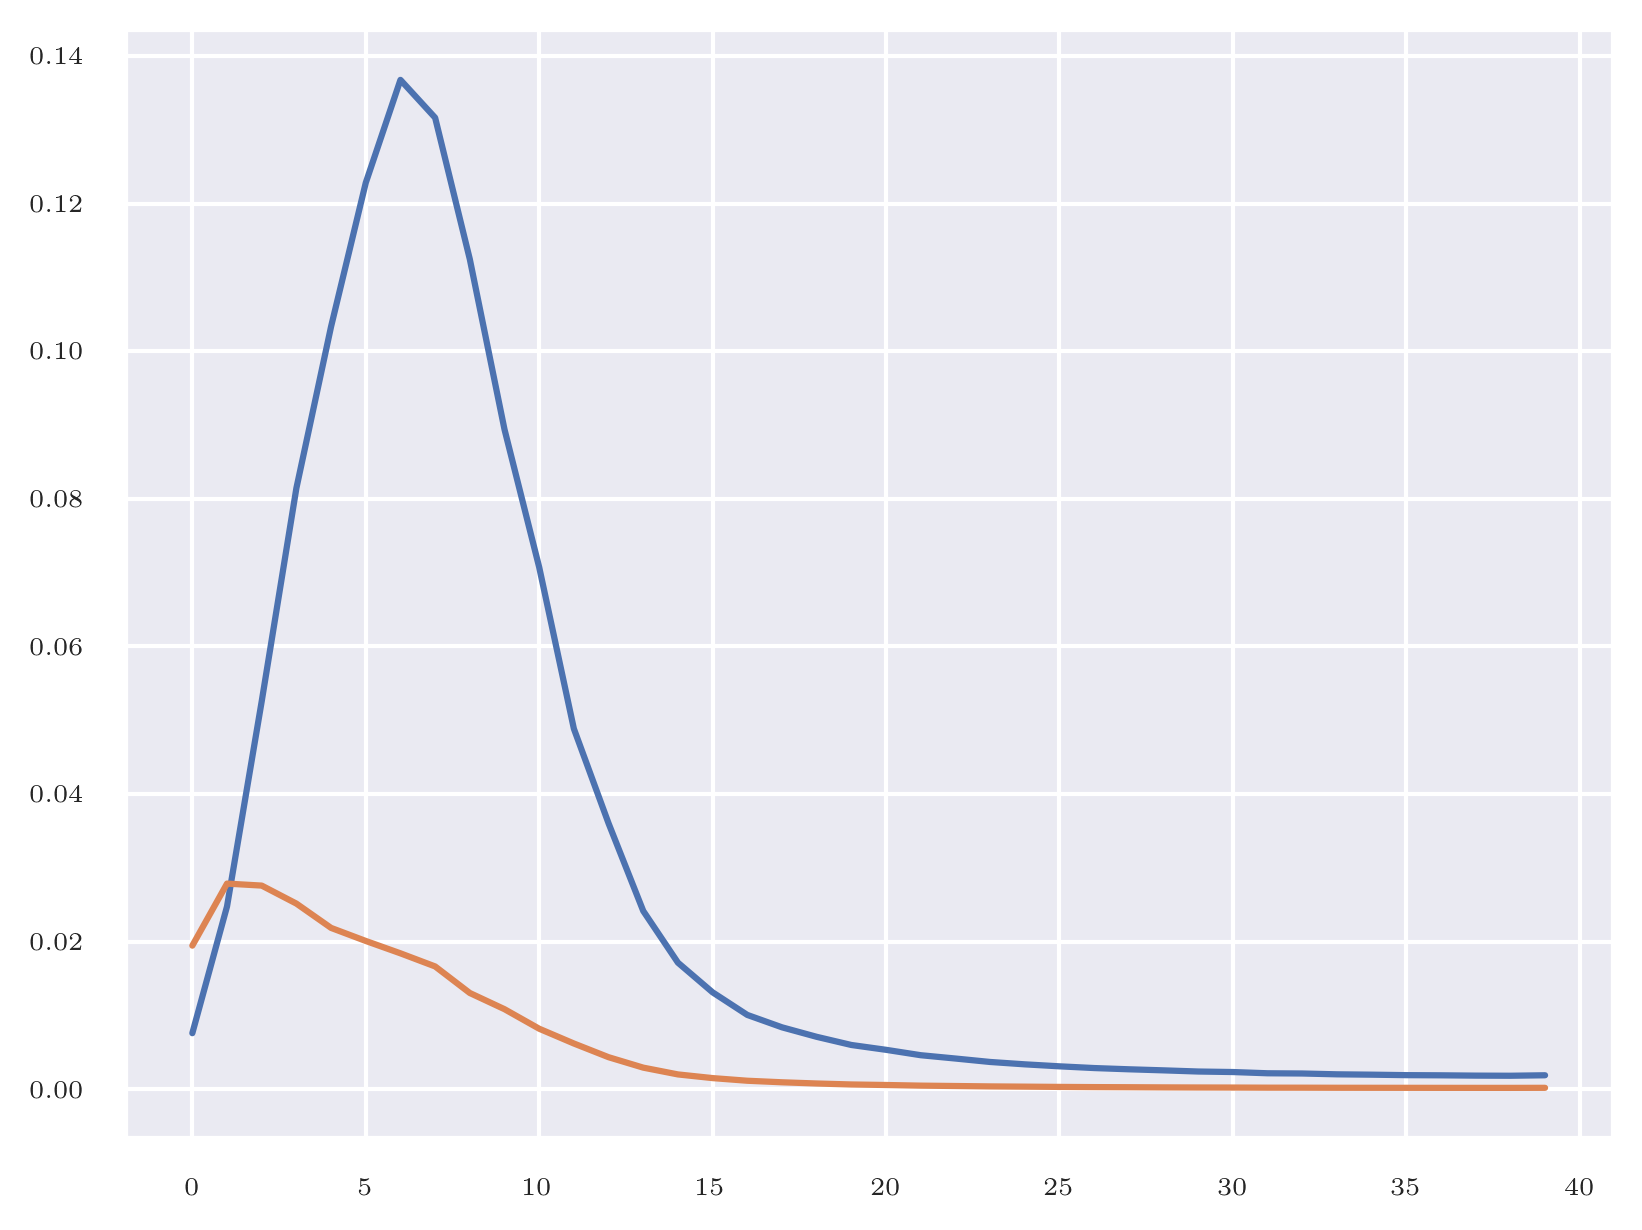

In [38]:
plt.plot(
    mse_mix_trans_sr_sr_trans.mean(0),
)
plt.plot(
    mse_mix_trans_sr_lasso.mean(0),
)

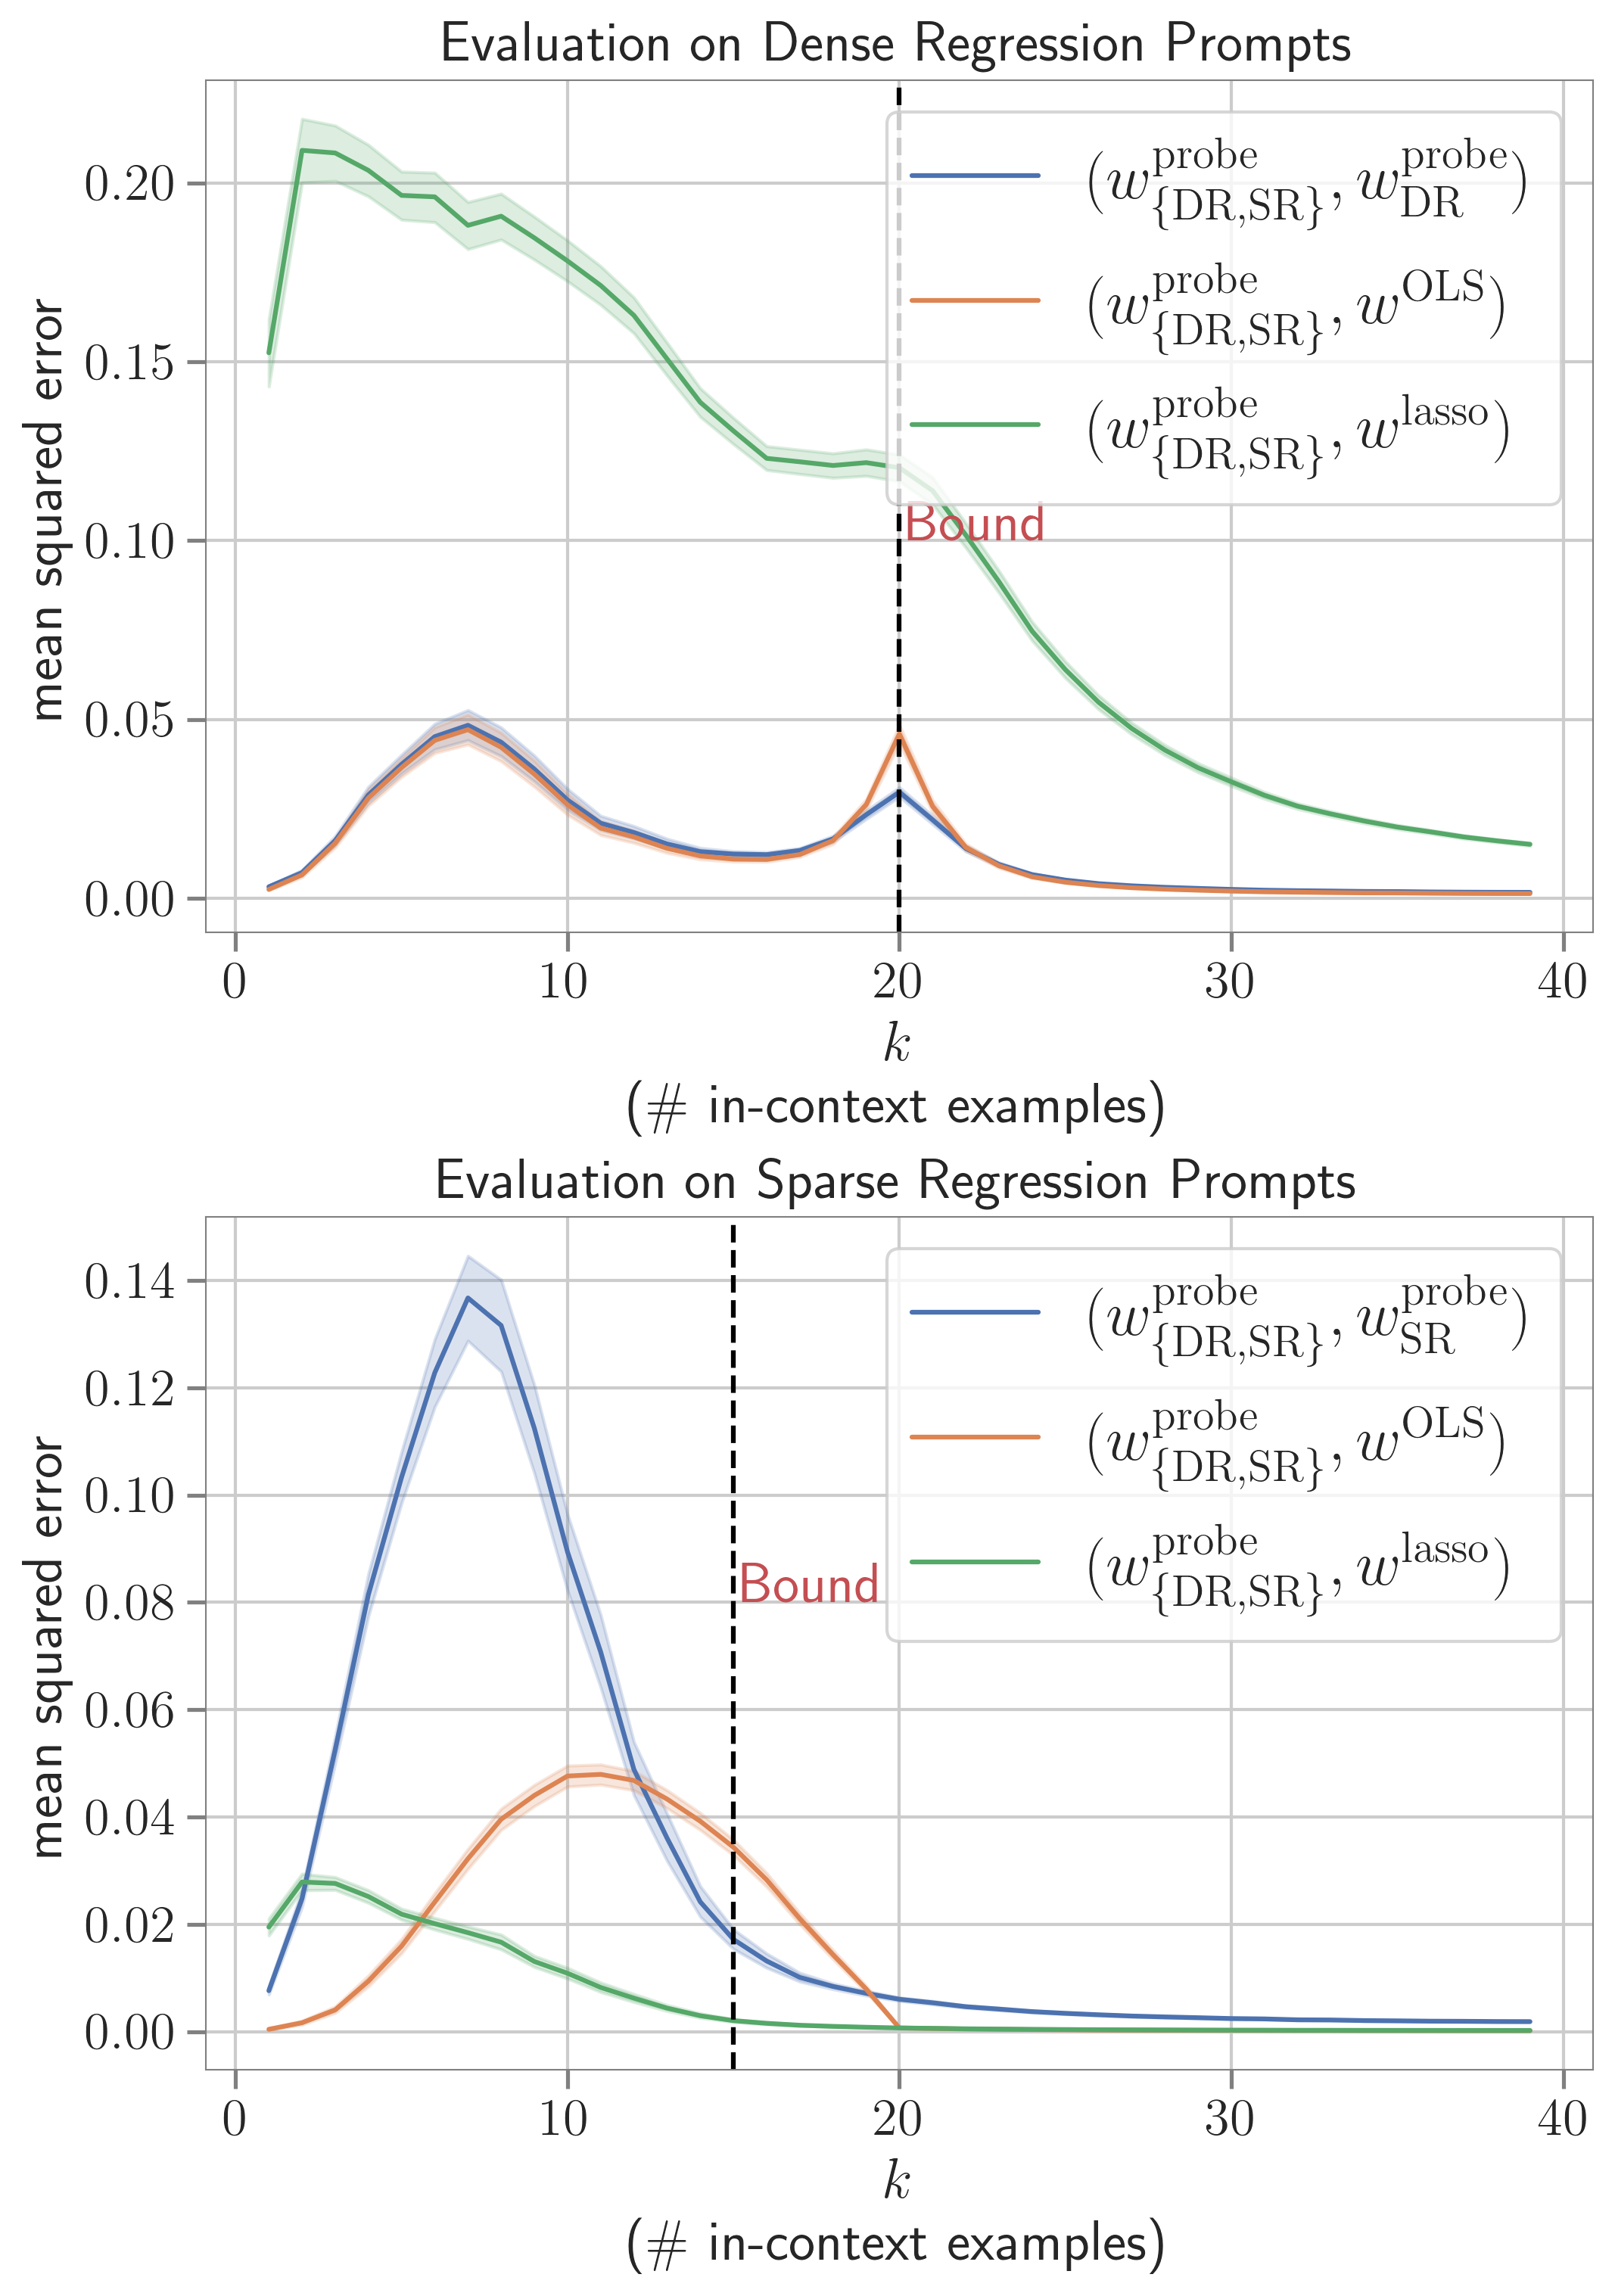

In [46]:
lr_bound = 20
sr_bound = 15

sns.set(style="whitegrid", font_scale=1.5)
# latexify(4, 3)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 10), constrained_layout=True)

# ax.plot(list(range(n_points)), transformer_pe_errors.mean(axis=0), label = "With Position Encodings")
# ax.plot(list(range(n_points)), transformer_no_pe_errors.mean(axis=0), label = "Without Position Encodings")
lineplot_with_ci(
    mse_mix_trans_lr_lr_trans[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{\mathrm{probe}}_{\mathrm{\{DR, SR\}}},w^{\mathrm{probe}}_{\mathrm{DR}})$",
    ax=ax1,
    seed=seed,
)
lineplot_with_ci(
    mse_mix_trans_lr_lsq[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{\mathrm{probe}}_{\mathrm{\{DR, SR\}}}, w^{\mathrm{OLS}})$",
    ax=ax1,
    seed=seed,
)
lineplot_with_ci(
    mse_mix_trans_lr_lasso[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{\mathrm{probe}}_{\mathrm{\{DR, SR\}}}, w^{\mathrm{lasso}})$",
    ax=ax1,
    seed=seed,
)
# lineplot_with_ci(cos_sims_linf_gold[:,:-1], n_points - 1,offset = 1, label="$(w^{\ell_{\infty}}, w)$", ax=ax, seed=seed)

# lineplot_with_ci(l2_norm_errors, n_points, label="L-2 Norm Min", ax=ax, seed=seed)
ax1.set_xlabel("$k$\n(\# in-context examples)")
ax1.set_ylabel("mean squared error")
ax1.set_title("Evaluation on Dense Regression Prompts")
format_axes(ax1)
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
ax1.axvline(lr_bound, ls="--", color="black")
ax1.annotate("Bound", xy=(lr_bound + 0.25, 0.1), color="r", rotation=0)
ax1.legend(fontsize=20)

lineplot_with_ci(
    mse_mix_trans_sr_sr_trans[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{\mathrm{probe}}_{\mathrm{\{DR, SR\}}},w^{\mathrm{probe}}_{\mathrm{SR}})$",
    ax=ax2,
    seed=seed,
)
lineplot_with_ci(
    mse_mix_trans_sr_lsq[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{\mathrm{probe}}_{\mathrm{\{DR, SR\}}}, w^{\mathrm{OLS}})$",
    ax=ax2,
    seed=seed,
)
lineplot_with_ci(
    mse_mix_trans_sr_lasso[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{\mathrm{probe}}_{\mathrm{\{DR, SR\}}}, w^{\mathrm{lasso}})$",
    ax=ax2,
    seed=seed,
)

# lineplot_with_ci(mse_mix_trans_sr_gold[:,:-1], n_points - 1,offset = 1, label="$(w^{\mathrm{probe}}, w)$", ax=ax2, seed=seed)
# lineplot_with_ci(mse_mix_trans_sr_lsq[:,:-1], n_points - 1, offset = 1, label="$(w^{\mathrm{probe}}, w^{\mathrm{OLS}})$", ax=ax2, seed=seed)
# # lineplot_with_ci(lsq_errors, n_points, label="Least Squares", ax=ax, seed=seed)
# lineplot_with_ci(mse_mix_trans_sr_lasso[:,:-1], n_points - 1,offset = 1, label="$(w^{\mathrm{probe}}, w^{\mathrm{lasso}})$", ax=ax2, seed=seed)
# # lineplot_with_ci(cos_sims_linf_gold[:,:-1], n_points - 1,offset = 1, label="$(w^{\ell_{\infty}}, w)$", ax=ax, seed=seed)

# lineplot_with_ci(l2_norm_errors, n_points, label="L-2 Norm Min", ax=ax, seed=seed)
ax2.set_xlabel("$k$\n(\# in-context examples)")
ax2.set_ylabel("mean squared error")
ax2.set_title("Evaluation on Sparse Regression Prompts")
format_axes(ax2)
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
ax2.axvline(sr_bound, ls="--", color="black")
ax2.annotate("Bound", xy=(sr_bound + 0.25, 0.08), color="r", rotation=0)
ax2.legend(fontsize=20)

# plt.legend()
plt.savefig("final_plots/lr_sr_mix_probing_msev2.pdf", dpi=300, bbox_inches="tight")
plt.show()

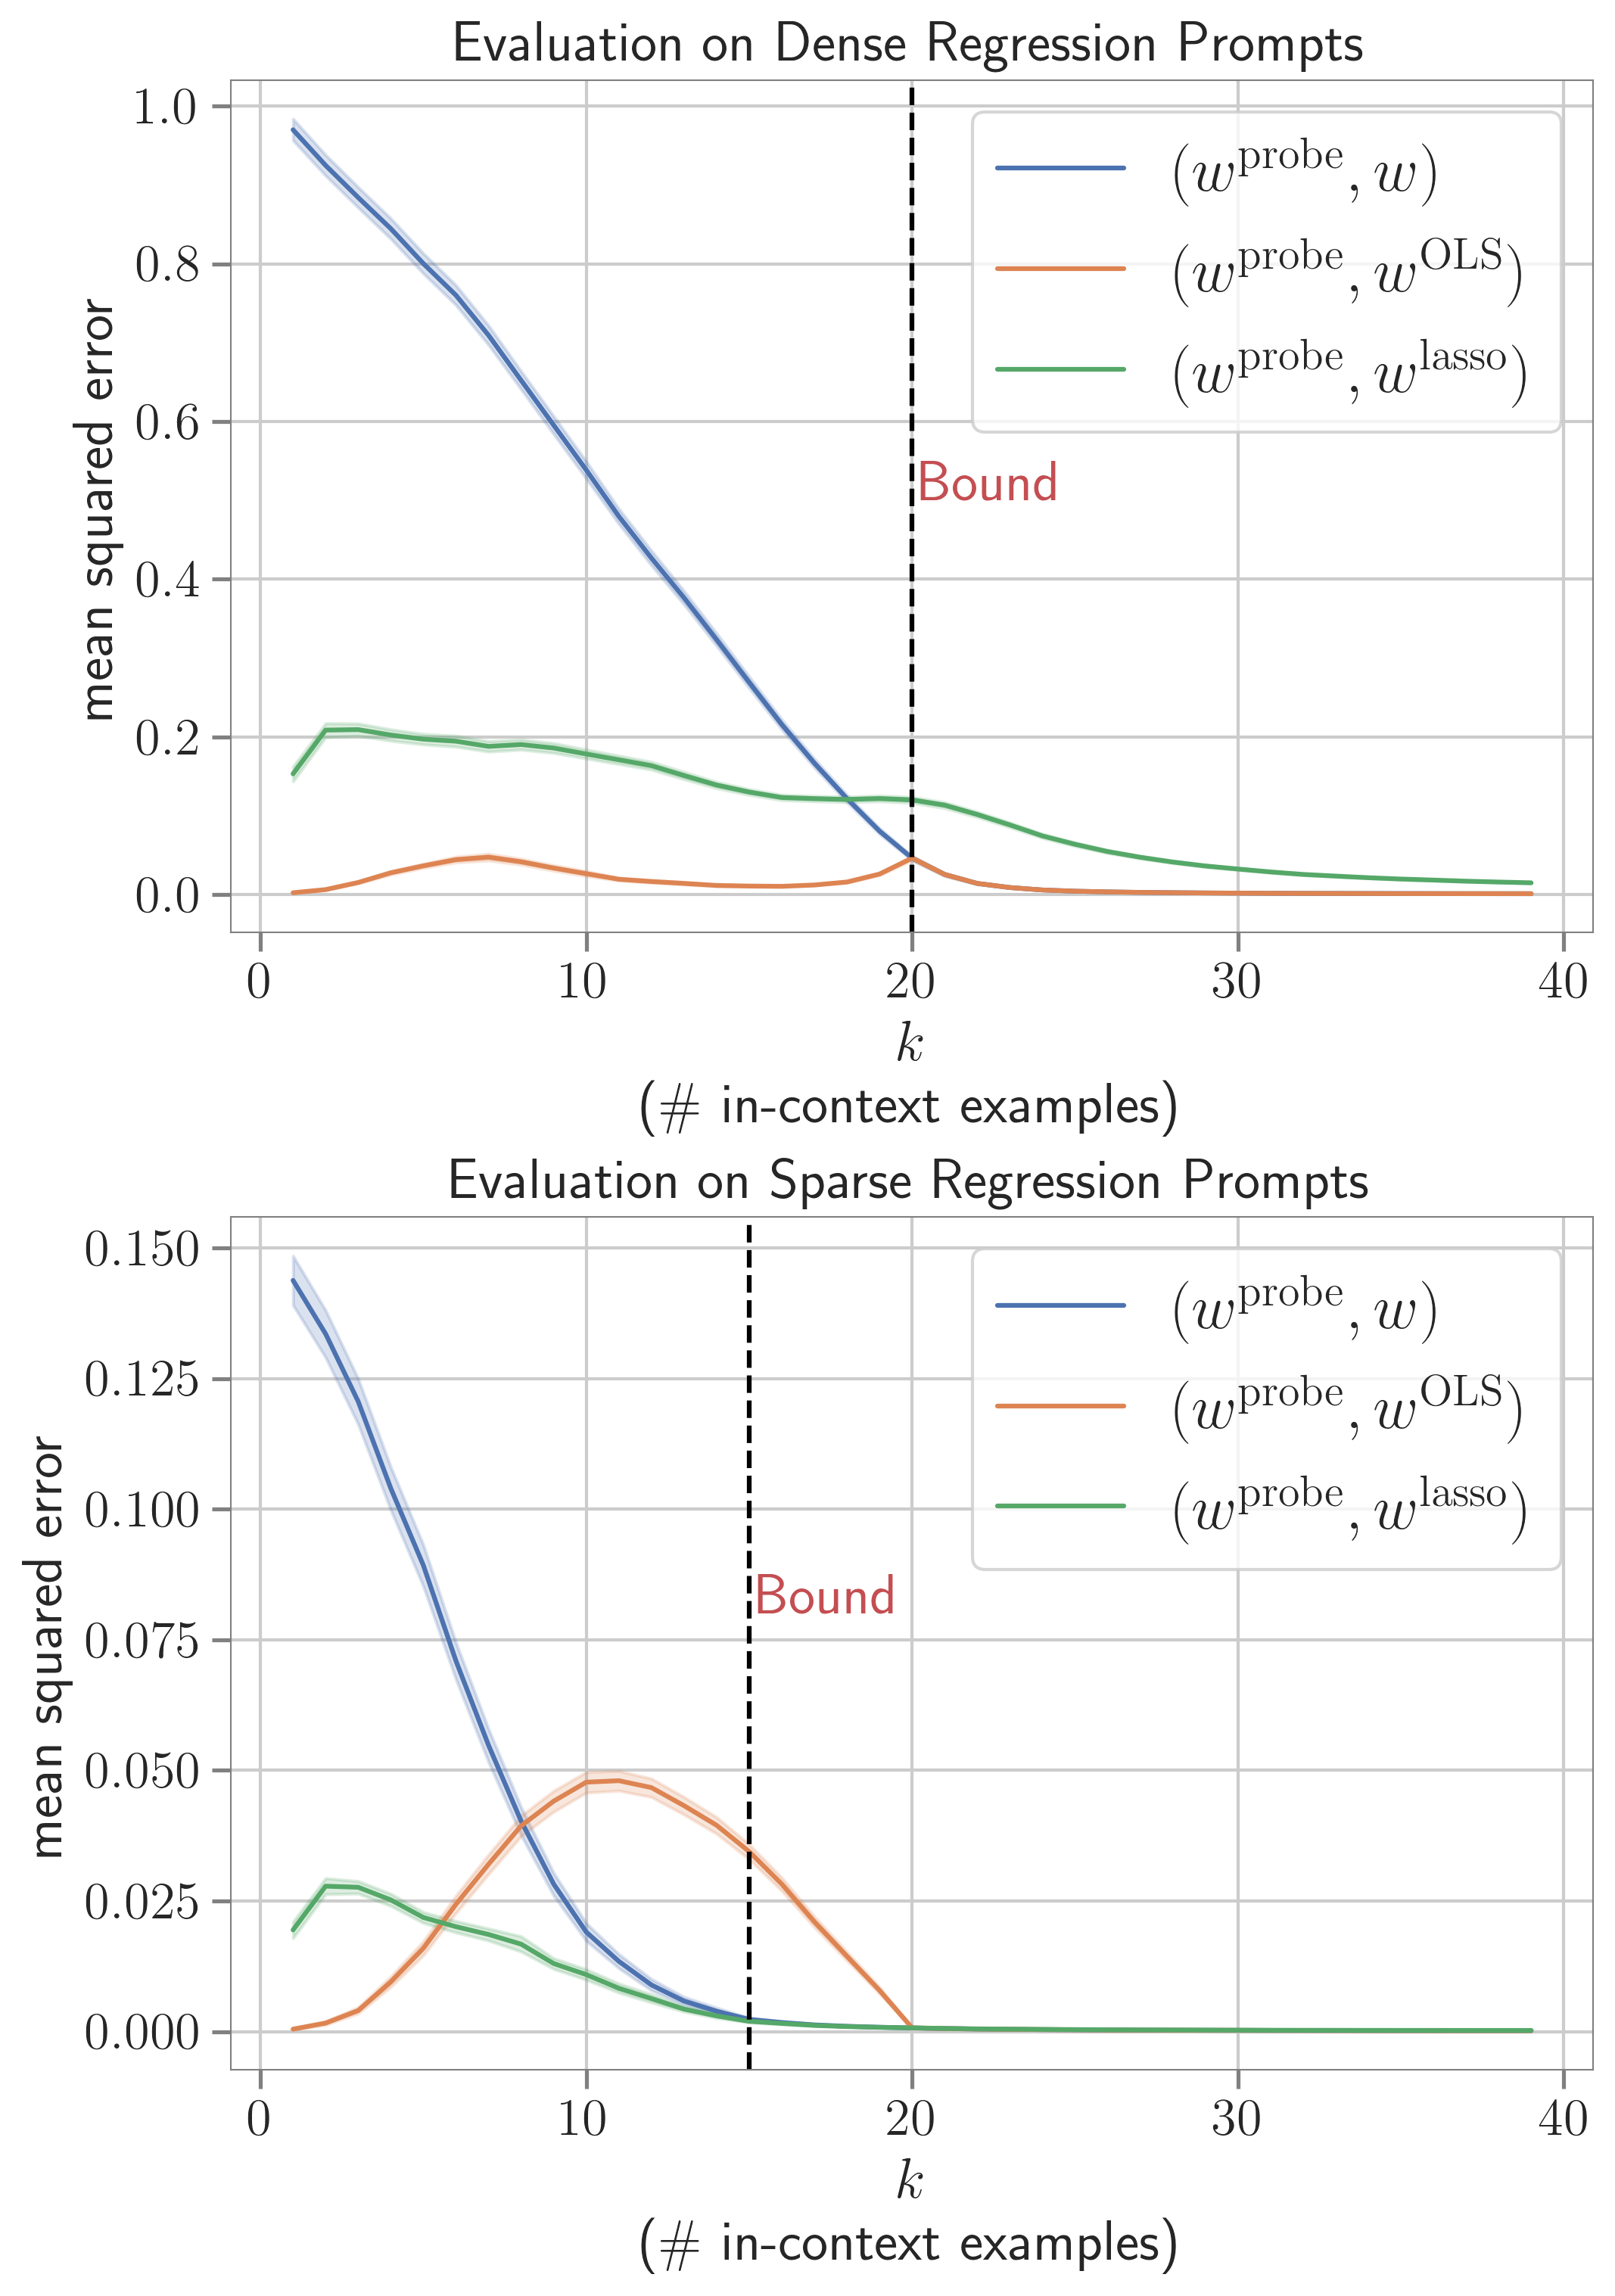

In [100]:
sns.set(style="whitegrid", font_scale=1.5)
# latexify(4, 3)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 10), constrained_layout=True)

# ax.plot(list(range(n_points)), transformer_pe_errors.mean(axis=0), label = "With Position Encodings")
# ax.plot(list(range(n_points)), transformer_no_pe_errors.mean(axis=0), label = "Without Position Encodings")
lineplot_with_ci(
    mse_mix_trans_lr_gold[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{\mathrm{probe}}, w)$",
    ax=ax1,
    seed=seed,
)
lineplot_with_ci(
    mse_mix_trans_lr_lsq[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{\mathrm{probe}}, w^{\mathrm{OLS}})$",
    ax=ax1,
    seed=seed,
)
# lineplot_with_ci(lsq_errors, n_points, label="Least Squares", ax=ax, seed=seed)
lineplot_with_ci(
    mse_mix_trans_lr_lasso[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{\mathrm{probe}}, w^{\mathrm{lasso}})$",
    ax=ax1,
    seed=seed,
)
# lineplot_with_ci(cos_sims_linf_gold[:,:-1], n_points - 1,offset = 1, label="$(w^{\ell_{\infty}}, w)$", ax=ax, seed=seed)

# lineplot_with_ci(l2_norm_errors, n_points, label="L-2 Norm Min", ax=ax, seed=seed)
ax1.set_xlabel("$k$\n(\# in-context examples)")
ax1.set_ylabel("mean squared error")
ax1.set_title("Evaluation on Dense Regression Prompts")
format_axes(ax1)
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
ax1.axvline(lr_bound, ls="--", color="black")
ax1.annotate("Bound", xy=(lr_bound + 0.25, 0.5), color="r", rotation=0)
ax1.legend(fontsize=20)

lineplot_with_ci(
    mse_mix_trans_sr_gold[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{\mathrm{probe}}, w)$",
    ax=ax2,
    seed=seed,
)
lineplot_with_ci(
    mse_mix_trans_sr_lsq[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{\mathrm{probe}}, w^{\mathrm{OLS}})$",
    ax=ax2,
    seed=seed,
)
# lineplot_with_ci(lsq_errors, n_points, label="Least Squares", ax=ax, seed=seed)
lineplot_with_ci(
    mse_mix_trans_sr_lasso[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{\mathrm{probe}}, w^{\mathrm{lasso}})$",
    ax=ax2,
    seed=seed,
)
# lineplot_with_ci(cos_sims_linf_gold[:,:-1], n_points - 1,offset = 1, label="$(w^{\ell_{\infty}}, w)$", ax=ax, seed=seed)

# lineplot_with_ci(l2_norm_errors, n_points, label="L-2 Norm Min", ax=ax, seed=seed)
ax2.set_xlabel("$k$\n(\# in-context examples)")
ax2.set_ylabel("mean squared error")
ax2.set_title("Evaluation on Sparse Regression Prompts")
format_axes(ax2)
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
ax2.axvline(sr_bound, ls="--", color="black")
ax2.annotate("Bound", xy=(sr_bound + 0.25, 0.08), color="r", rotation=0)
ax2.legend(fontsize=20)

# plt.legend()
plt.savefig("final_plots/lr_sr_mix_probing_mse.pdf", dpi=300, bbox_inches="tight")
plt.show()

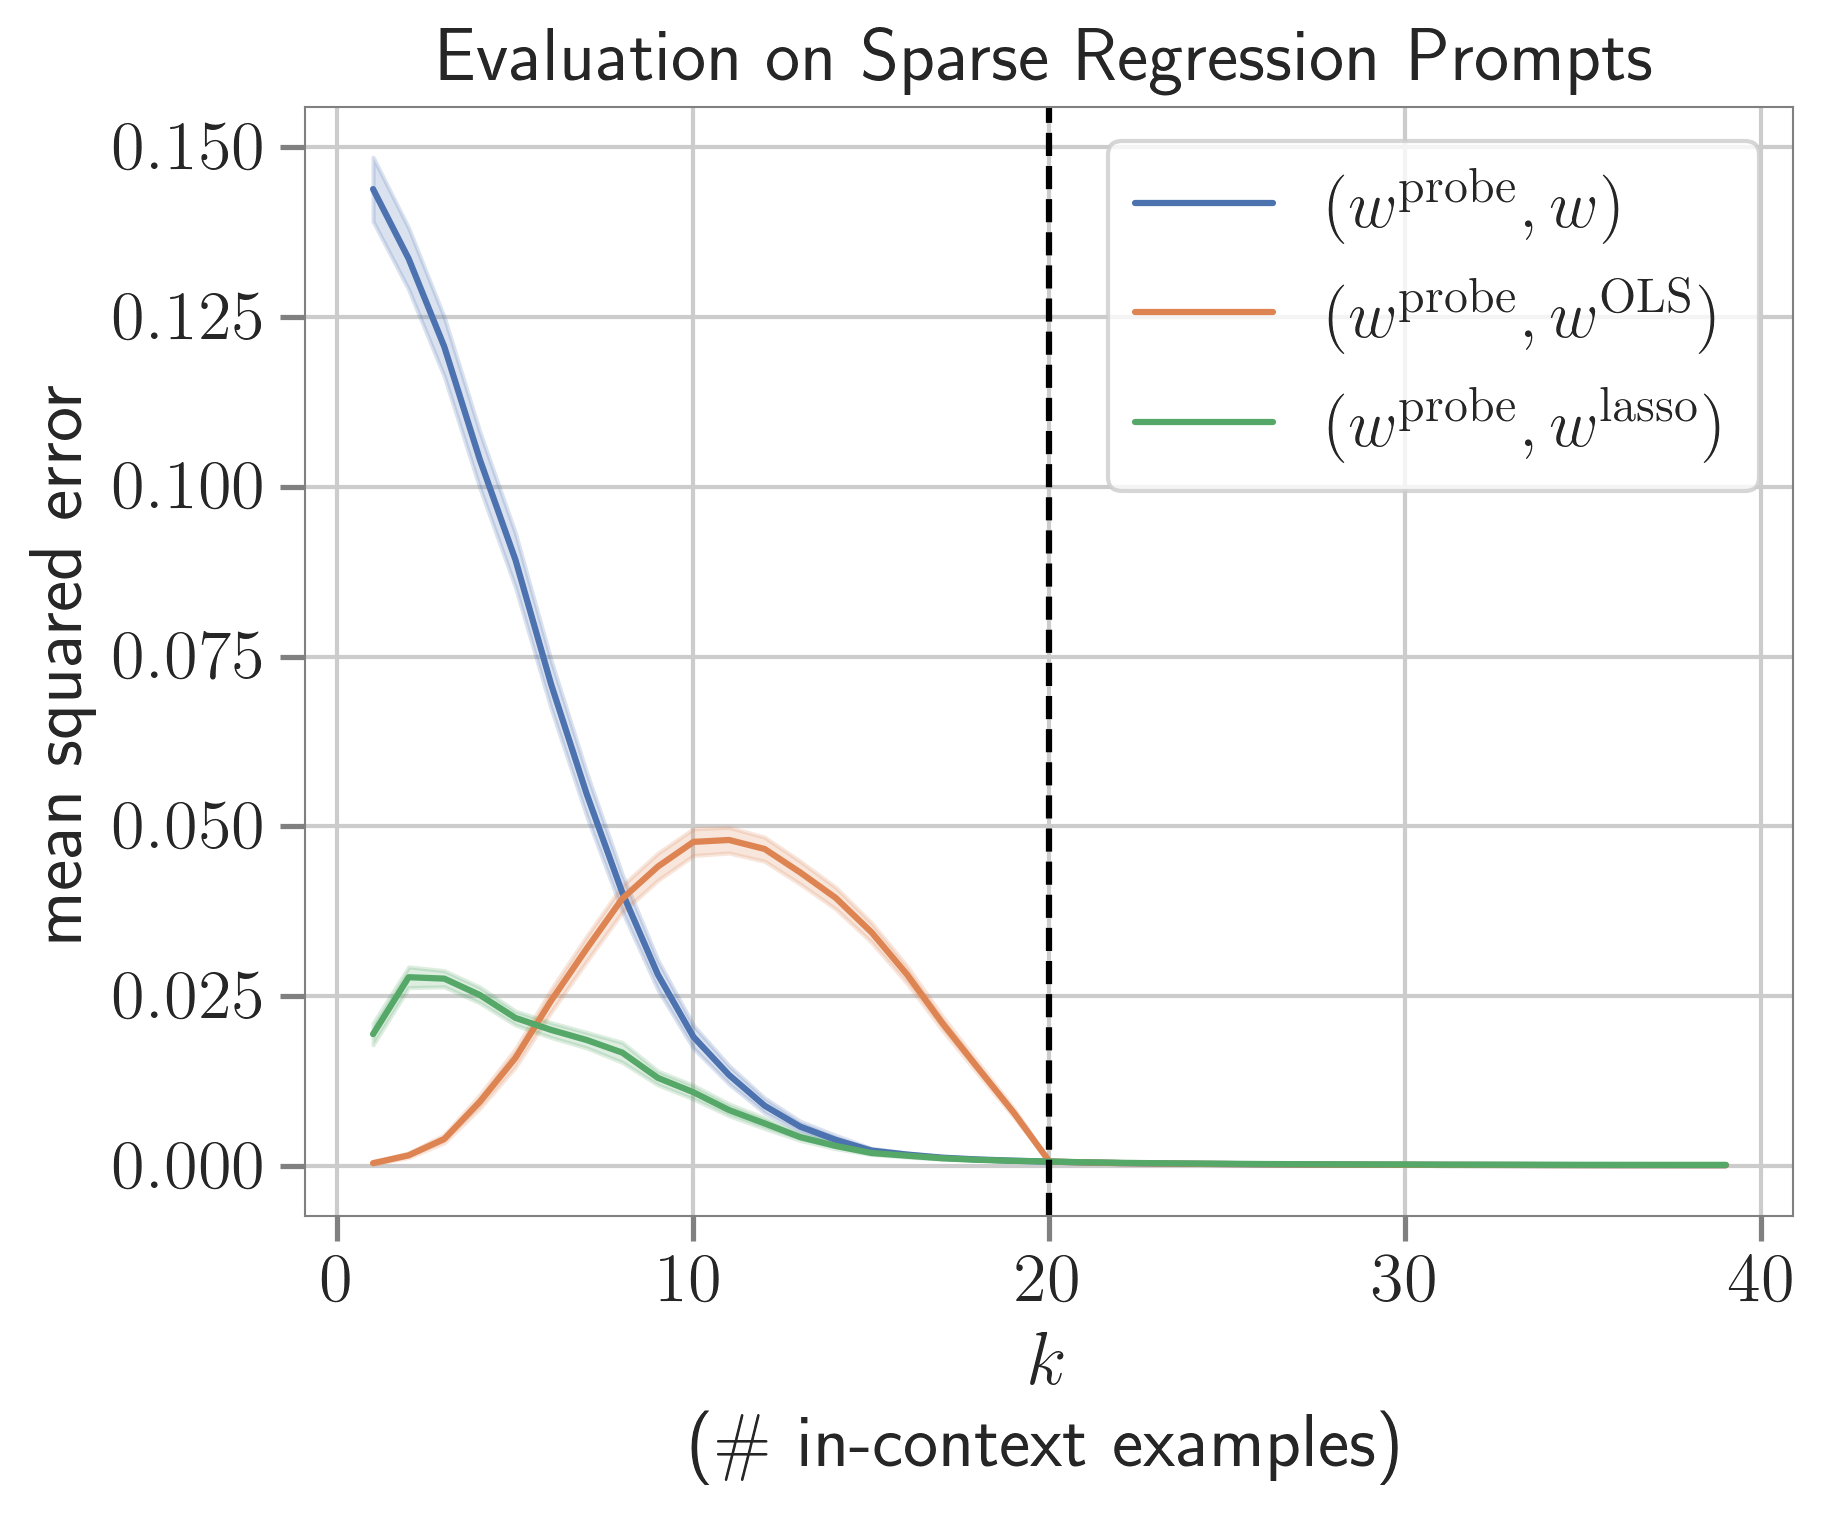

In [89]:
sns.set(style="whitegrid", font_scale=1.5)
# latexify(4, 3)

fig, ax = plt.subplots()
# ax.plot(list(range(n_points)), transformer_pe_errors.mean(axis=0), label = "With Position Encodings")
# ax.plot(list(range(n_points)), transformer_no_pe_errors.mean(axis=0), label = "Without Position Encodings")
lineplot_with_ci(
    mse_mix_trans_sr_gold[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{\mathrm{probe}}, w)$",
    ax=ax,
    seed=seed,
)
lineplot_with_ci(
    mse_mix_trans_sr_lsq[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{\mathrm{probe}}, w^{\mathrm{OLS}})$",
    ax=ax,
    seed=seed,
)
# lineplot_with_ci(lsq_errors, n_points, label="Least Squares", ax=ax, seed=seed)
lineplot_with_ci(
    mse_mix_trans_sr_lasso[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{\mathrm{probe}}, w^{\mathrm{lasso}})$",
    ax=ax,
    seed=seed,
)
# lineplot_with_ci(cos_sims_linf_gold[:,:-1], n_points - 1,offset = 1, label="$(w^{\ell_{\infty}}, w)$", ax=ax, seed=seed)

# lineplot_with_ci(l2_norm_errors, n_points, label="L-2 Norm Min", ax=ax, seed=seed)
ax.set_xlabel("$k$\n(\# in-context examples)")
ax.set_ylabel("mean squared error")
ax.set_title("Evaluation on Sparse Regression Prompts")
format_axes(ax)
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.axvline(lr_bound, ls="--", color="black")
ax.annotate("Bound", xy=(lr_bound + 0.25, 0.5), color="r", rotation=0)
plt.legend()
# plt.savefig("final_plots/svr_probing_mse.pdf", dpi = 300, bbox_inches = "tight")
plt.show()